# Prediction performance on inter-protein PTM cross-talk

## Load functions and data

In [1]:
import numpy as np
from os.path import expanduser

data_dir = expanduser("~") + "/research/PTM-X/"

positive_file = data_dir + "/interface/positive_features_merge.txt"
feature_positive = np.loadtxt(positive_file, delimiter='\t', skiprows=0, dtype="str")

negative_file = data_dir + "/interface/negative_features_merge.txt"
feature_negative = np.loadtxt(negative_file, delimiter='\t', skiprows=0, dtype="str")

In [2]:
feature_positive[0,:]

array(['P12814', 'Y12', 'phosphorylation', 'Q05397', 'Y397',
       'phosphorylation', '1.000', '0.010', '0.333', 'nan'], 
      dtype='|S19')

### Removing missing values

In [3]:
X1 = feature_positive[:,6:10].astype(float)
X2 = feature_negative[:,6:10].astype(float)
X1[:,-1] = -np.log10(X1[:,-1])
X2[:,-1] = -np.log10(X2[:,-1])
idx1 = np.mean(X1 == X1, axis=1) == 1
idx2 = np.mean(X2 == X2, axis=1) == 1
X1 = X1[idx1,:]
X2 = X2[idx2,:]
len1 = X1.shape[0]
len2 = X2.shape[0]

In [8]:
import sys
sys.path.append('../scr')

from utils.classifier import KernalNB, CrossValidation
NB_model = KernalNB()

from sklearn.svm import SVC
SVC_linear = SVC(probability=True, kernel="linear")

from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=100, n_jobs=-1)

from sklearn import linear_model
LR_model = linear_model.LogisticRegression()

from sklearn.metrics import roc_auc_score

methods = [NB_model, SVC_linear, LR_model, RF_model]

n_rep = 20
auc_all = np.zeros((n_rep, 4))
for i in range(n_rep):
    idx = np.random.choice(len2, len1)
    X_use = np.append(X1, X2[idx], axis=0)
    Y_use = np.append(np.ones(len1), np.zeros(len1))
    
    for j in range(len(methods)):
        CV = CrossValidation(X_use, Y_use)
        Ystate, Yscore = CV.cv_classification(model=methods[j], folds=10)
        auc_all[i,j] = roc_auc_score(Y_use, Yscore[:,1])

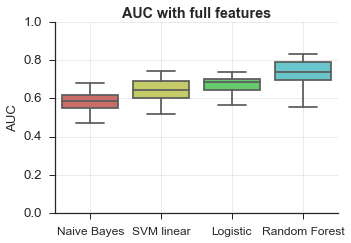

In [10]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../scr')
from plot.ROC_plot import ROC_plot, set_style

set_style()
sns.set_palette(sns.color_palette("hls", 6))

fig = plt.figure(figsize=(5,3.5))
sns.boxplot(data = auc_all)
plt.ylim(0,1)

plt.ylabel("AUC")
plt.xticks(np.arange(4), ["Naive Bayes", "SVM linear", "Logistic", "Random Forest"])
plt.title("AUC with full features")
plt.grid(alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(data_dir + "/figures/AUC_compare.pdf")
plt.show()

### Imputing features by mean

In [12]:
len1 = feature_positive.shape[0]
len2 = feature_negative.shape[0]

X = np.append(feature_positive[:,6:10], feature_negative[:,6:10], axis=0).astype(float)
Y = np.append(np.ones(len1), np.zeros(len2))
X[:,3] = -np.log10(X[:,3])

In [18]:
X_raw = np.copy(X)
pred_raw = []
idx_use = [[0], [1], [2], [3], [0,1,2,3]]
for i in range(len(idx_use)):
    idx_point = np.mean(X_raw[:, idx_use[i]] == X_raw[:, idx_use[i]], axis=1) == 1
    xx = X_raw[:, idx_use[i]][idx_point]
    yy = Y[idx_point]
    print(sum(idx_point))
    
    CV = CrossValidation(xx, yy)
    Ystate, Yscore = CV.cv_classification(model=RF_model, folds=10)
    pred_raw.append([Y[idx_point], Yscore[:,1]])

8587
6125
6939
649
578


In [19]:
from sklearn.preprocessing import Imputer
none_imputer = Imputer(strategy="median")
X_imp = none_imputer.fit_transform(X)

pred_imp = []

idx_use = [[0], [1], [2], [3], [0,1,2,3]]
for i in range(len(idx_use)):
    idx_point = np.mean(X_imp[:, idx_use[i]] == X_imp[:, idx_use[i]], axis=1) == 1
    xx = X_imp[:, idx_use[i]][idx_point]
    yy = Y[idx_point]
    print(sum(idx_point))
    
    CV = CrossValidation(xx, yy)
    Ystate, Yscore = CV.cv_classification(model=RF_model, folds=10)
    pred_imp.append([Y[idx_point], Yscore[:,1]])

8587
8587
8587
8587
8587


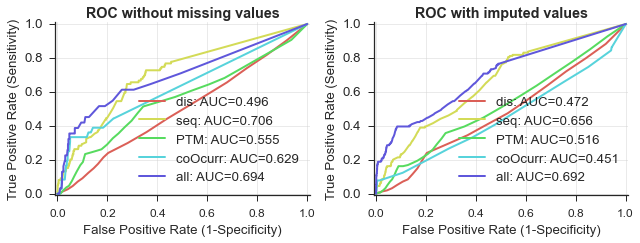

In [28]:
fig = plt.figure(figsize=(9,3.5))

methods = ["dis", "seq", "PTM", "coOcurr", "all"]
plt.subplot(1,2,1)
for i in range(5):
    ROC_plot(pred_raw[i][0], pred_raw[i][1], label=methods[i], linewidth=2, base_line=False)

plt.title("ROC without missing values")
sns.despine()
plt.grid(alpha=0.4)

plt.subplot(1,2,2)
for i in range(5):
    ROC_plot(pred_imp[i][0], pred_imp[i][1], label=methods[i], linewidth=2, base_line=False)

plt.title("ROC with imputed values")
sns.despine()
plt.grid(alpha=0.4)
plt.tight_layout()
fig.savefig(data_dir + "figures/RF_imputation.pdf", dpi=300, bbox_inches='tight')
plt.show()

### test without disordered region

578


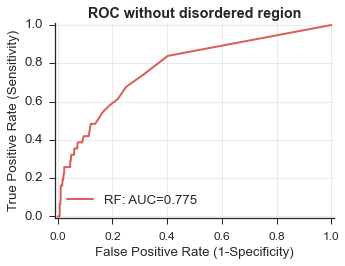

In [32]:
np.random.seed(0)

idx_use = [[1,2,3]]
fig = plt.figure(figsize=(5,3.5))
for i in range(len(idx_use)):
    idx_point = np.mean(X_raw[:, idx_use[i]] == X_raw[:, idx_use[i]], axis=1) == 1
    xx = X_raw[:, idx_use[i]][idx_point]
    yy = Y[idx_point]

    print(sum(idx_point))
    
    CV = CrossValidation(xx, yy)
    Ystate, Yscore = CV.cv_classification(model=RF_model, folds=10)
    ROC_plot(Y[idx_point], Yscore[:,1], label="RF", linewidth=2, base_line=False)
    plt.title("ROC without disordered region")

sns.despine()
plt.grid(alpha=0.4)
fig.set_size_inches(5,3.5)
# fig.savefig("cv_classification.pdf", dpi=300, bbox_inches='tight')
plt.show()